In [1]:
'''!pip install kaggle --quiet

import os
os.environ['KAGGLE_CONFIG_DIR'] = "~/.kaggle"  # Update this path if needed

# I had to do this because it wasn't seeing my kaggle.json
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

!kaggle competitions download -c rsna-pneumonia-detection-challenge

import zipfile
with zipfile.ZipFile('rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
    zip_ref.extractall('rsna_data')

import os
os.listdir('rsna_data')'''

'!pip install kaggle --quiet\n\nimport os\nos.environ[\'KAGGLE_CONFIG_DIR\'] = "~/.kaggle"  # Update this path if needed\n\n# I had to do this because it wasn\'t seeing my kaggle.json\nos.environ[\'KAGGLE_USERNAME\'] = \'\'\nos.environ[\'KAGGLE_KEY\'] = \'\'\n\n!kaggle competitions download -c rsna-pneumonia-detection-challenge\n\nimport zipfile\nwith zipfile.ZipFile(\'rsna-pneumonia-detection-challenge.zip\', \'r\') as zip_ref:\n    zip_ref.extractall(\'rsna_data\')\n\nimport os\nos.listdir(\'rsna_data\')'

In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121 
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras import layers, models
import cv2

data_dir = '../brain-tumor-classification/rsna_data/stage_2_train_images'
labels_df = pd.read_csv('../brain-tumor-classification/rsna_data/stage_2_train_labels.csv')

def load_dicom_image(image_path):
    dicom_data = pydicom.dcmread(image_path)
    
    image = dicom_data.pixel_array
    
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB
    
    image = cv2.resize(image, (224, 224))
    
    image = image / 255.0
    
    image = (image * 255).astype(np.uint8)
    
    return image

images = []
labels = []
for idx, row in labels_df.iterrows():
    image_path = os.path.join(data_dir, f'{row["patientId"]}.dcm')
    images.append(load_dicom_image(image_path))
    labels.append(row["Target"])

images = np.array(images)
labels = np.array(labels)


2025-05-12 19:16:01.072421: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 19:16:01.227622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747091761.289114     935 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747091761.305824     935 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 19:16:01.450851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

'''
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [2]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input

from tensorflow.keras.applications import MobileNetV2
inputs = Input(shape=(224, 224, 3))


x = inputs
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model(x, training=False)

# Custom classification head
'''
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
'''
x = GlobalAveragePooling2D()(x)
x = Dense(2048)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)


model = Model(inputs, outputs)


I0000 00:00:1747193826.542576   34659 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19946 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,519,297 (28.68 MB)

 Trainable params: 5,254,145 (20.04 MB)

 Non-trainable params: 2,265,152 (8.64 MB)

In [5]:

from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [6]:
from tensorflow.keras import callbacks
# --- TRAINING ---
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.001, monitor='val_accuracy', mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop]
)

/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747019020.418780   81325 service.cc:148] XLA service 0x7efd4c002020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747019020.418811   81325 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-05-11 23:03:40.509783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747019020.931719   81325 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-11 23:03:41.641636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431_0', 56 bytes spill stores, 56 bytes spill loads

2025-05-11 23:03:41.671815: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 16 byt

  6/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.4946 - loss: 0.8306

I0000 00:00:1747019025.182871   81325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


757/851 ━━━━━━━━━━━━━━━━━━━━ 48s 520ms/step - accuracy: 0.7370 - loss: 0.5543 

2025-05-11 23:10:23.552323: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[15,144,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,24,56,56]{3,2,1,0}, f32[144,24,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-11 23:10:23.558806: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m10.918931921s
Trying algorithm eng3{k11=0} for conv (f32[15,144,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,24,56,56]{3,2,1,0}, f32[144,24,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_r

851/851 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.7399 - loss: 0.5483 - val_accuracy: 0.7880 - val_loss: 0.4461
Epoch 2/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7892 - loss: 0.4497 - val_accuracy: 0.8048 - val_loss: 0.4187
Epoch 3/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7999 - loss: 0.4267 - val_accuracy: 0.7959 - val_loss: 0.4252
Epoch 4/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8073 - loss: 0.4127 - val_accuracy: 0.8108 - val_loss: 0.4138
Epoch 5/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8206 - loss: 0.3943 - val_accuracy: 0.8111 - val_loss: 0.4078
Epoch 6/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8235 - loss: 0.3905 - val_accuracy: 0.8091 - val_loss: 0.4048
Epoch 7/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8285 - loss: 0.3746 - val_accuracy: 0.8157 - val_loss: 0.4075
Epoch 8/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8338 - loss: 0.3691 - val_accuracy: 0.8154 - va

In [ ]:
model.save("cnn_chest_pretune_resnet.keras")
from tensorflow.keras.models import load_model
#model = load_model("cnn_chest_pretune.keras")
base_model.trainable = True

#for layer in base_model.layers[-30:]:
#   layer.trainable = True

In [8]:
classifier_head_weights = [layer.get_weights() for layer in model.layers[-16:]]


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [10]:

for i, layer in enumerate(model.layers[-16:]):
    layer.set_weights(classifier_head_weights[i])


In [11]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50


2025-05-11 23:05:34.769474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8326', 60 bytes spill stores, 180 bytes spill loads



562/851 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7671 - loss: 0.5028  

2025-05-11 23:05:43.584132: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8326', 4 bytes spill stores, 4 bytes spill loads

2025-05-11 23:11:56.522779: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_63894__.12027] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


851/851 ━━━━━━━━━━━━━━━━━━━━ 22s -420282us/step - accuracy: 0.7737 - loss: 0.4875 - val_accuracy: 0.7853 - val_loss: 0.4624 - learning_rate: 1.0000e-05
Epoch 2/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8213 - loss: 0.3984 - val_accuracy: 0.8068 - val_loss: 0.4198 - learning_rate: 1.0000e-05
Epoch 3/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8358 - loss: 0.3669 - val_accuracy: 0.8227 - val_loss: 0.3916 - learning_rate: 1.0000e-05
Epoch 4/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8534 - loss: 0.3340 - val_accuracy: 0.8267 - val_loss: 0.3943 - learning_rate: 1.0000e-05
Epoch 5/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8705 - loss: 0.2967 - val_accuracy: 0.8343 - val_loss: 0.3940 - learning_rate: 1.0000e-05
Epoch 6/50
408/851 ━━━━━━━━━━━━━━━━━━━━ 6:48 921ms/step - accuracy: 0.8977 - loss: 0.2453
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.

In [12]:
model.save("cnn_chest_tall_tuned.keras")

In [4]:
from tensorflow.keras.models import load_model
model = load_model("cnn_chest_tall_tuned.keras")

I0000 00:00:1747091916.020637     935 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


 2/95 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step

/home/anderson_walsh/UTK/COSC523Project2/nlp/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
y_pred shape: (3023,)
y_true shape: (3023,)
First 10 predictions: [0 1 0 0 1 1 1 0 0 0]
First 10 labels: [0 1 0 0 1 0 0 0 0 0]
Validation Accuracy: 0.8439


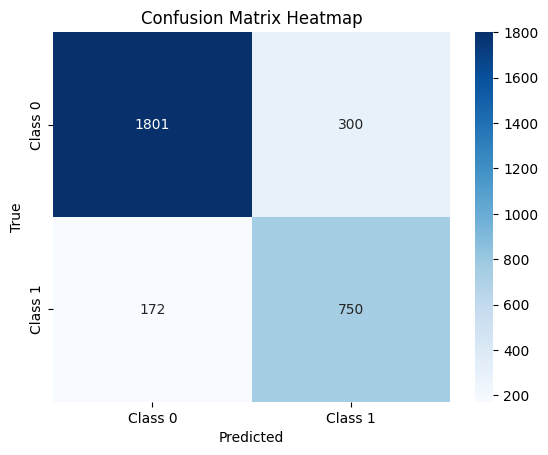

'\ny_pred = model.predict(validation_generator)\n\ny_true = []\nfor _, label_batch in validation_generator:\n    y_true.append(label_batch)\n\ny_true = np.concatenate(y_true, axis=0)\n\ny_true = np.argmax(y_true, axis=1)\n\ny_pred = np.argmax(y_pred, axis=1)\n\nacc = accuracy_score(y_true, y_pred)\nprint(f"CNN Accuracy: {acc:.4f}")\n\nconf_matrix = confusion_matrix(y_true, y_pred)\nsns.heatmap(conf_matrix, annot=True, fmt=\'d\', cmap=\'Blues\', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'True\')\nplt.show()\n'

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure your validation generator is NOT shuffled
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)

# Predict class probabilities
y_probs = model.predict(validation_generator, verbose=1)

# Convert sigmoid outputs to binary class predictions
y_pred = (y_probs > 0.5).astype("int32").flatten()

# Get true labels (from flow())
y_true = validation_generator.y

# If one-hot encoded, convert to class indices
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Ensure they're flat and integer type
y_true = y_true.astype("int32").flatten()

# Debug: check alignment
print("y_pred shape:", y_pred.shape)
print("y_true shape:", y_true.shape)
print("First 10 predictions:", y_pred[:10])
print("First 10 labels:", y_true[:10])

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
acc = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {acc:.4f}")

precision = precision_score(y_true, y_pred, average=None)  # per class precision
recall = recall_score(y_true, y_pred, average=None)  # per class recall
f1 = f1_score(y_true, y_pred, average=None)  # per class f1 score

print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("\nOverall (macro average) Precision:", precision_macro)
print("Overall (macro average) Recall:", recall_macro)
print("Overall (macro average) F1 Score:", f1_macro)

report = classification_report(y_true, y_pred, target_names=["class 0", "class 1"])
print("\nClassification Report:\n", report)

CNN Accuracy: 0.8439
Precision (per class): [0.91282311 0.71428571]
Recall (per class): [0.85721085 0.81344902]
F1 Score (per class): [0.88414335 0.76064909]

Overall (macro average) Precision: 0.8135544131489393
Overall (macro average) Recall: 0.8353299379182106
Overall (macro average) F1 Score: 0.8223962176409846

Classification Report:
               precision    recall  f1-score   support

     class 0       0.91      0.86      0.88      2101
     class 1       0.71      0.81      0.76       922

    accuracy                           0.84      3023
   macro avg       0.81      0.84      0.82      3023
weighted avg       0.85      0.84      0.85      3023



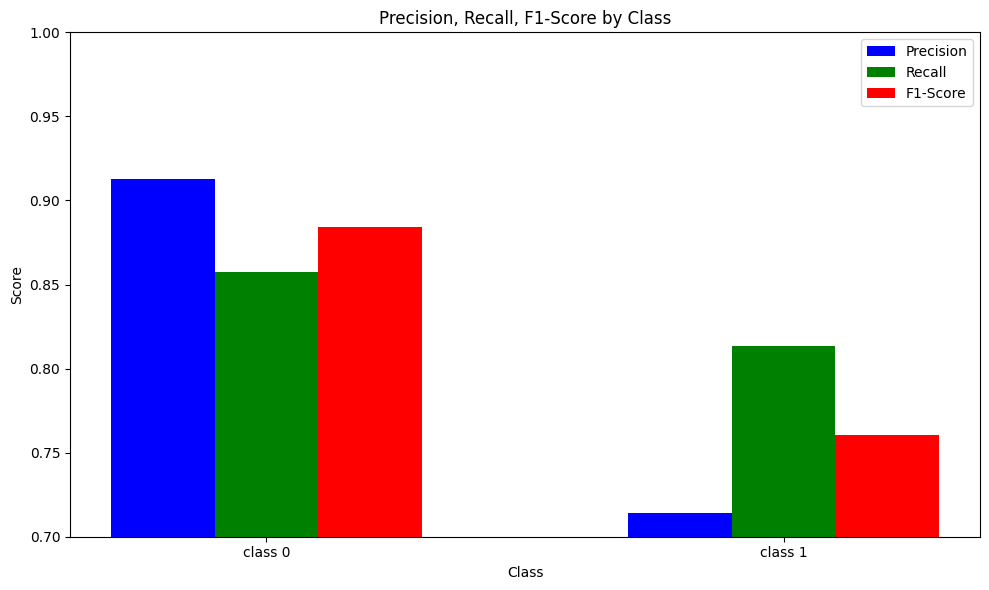

: 

In [ ]:
precision = [0.91282311, 0.71428571]
recall = [0.85721085, 0.81344902]
f1_score = [0.88414335, 0.76064909]

classes = ['class 0', 'class 1']

bar_width = 0.2
index = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, precision, bar_width, label='Precision', color='blue')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='green')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', color='red')


ax.set_ylim(0.7, 1)
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()